https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/

In [1]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import numpy as np
import math
from sklearn.model_selection import train_test_split, cross_validate
import string

In [2]:
SARA_FILEPATH = '/Users/sarakent/Desktop/ML 1/TMDB_movie_dataset_v11.csv'

In [3]:
imdb_df = pd.read_csv(SARA_FILEPATH)
imdb_df['release_date'] = pd.to_datetime(imdb_df.release_date)
imdb_df = imdb_df[(imdb_df['status'] == 'Released') & 
        (imdb_df['budget'] > 10000) & 
        (imdb_df['release_date'].notna()) & 
        (imdb_df['genres'].notna()) &
        (imdb_df['runtime'] != 0) & 
        (imdb_df['release_date'] > '1950-01-01') &
        (imdb_df['tagline'].notna()) &
        (imdb_df['overview'].notna())]

In [4]:
imdb_df.head(1)

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,...,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc..."


### Plot Revenue over Time

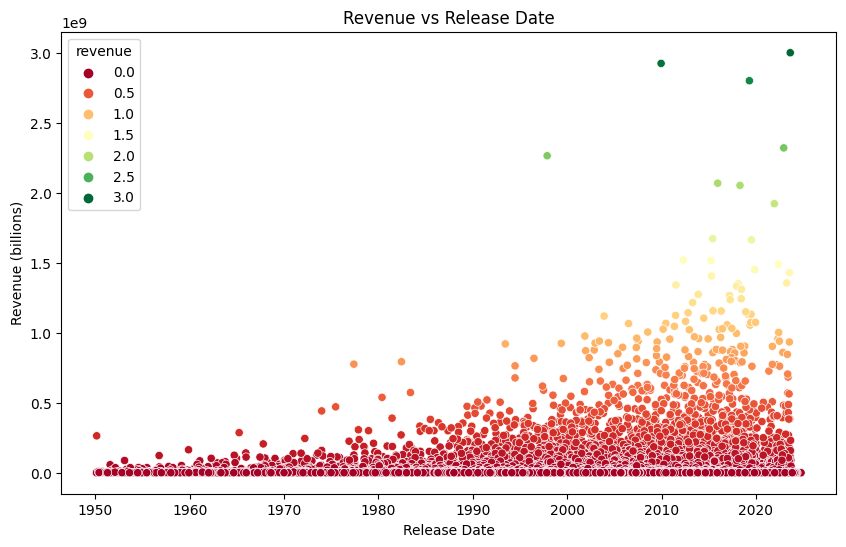

In [5]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=imdb_df, x='release_date', y='revenue', hue='revenue', palette='RdYlGn')

# labels and title
plt.xlabel('Release Date')
plt.ylabel('Revenue (billions)')
plt.title('Revenue vs Release Date')

plt.show()

### Look at Revenue vs Budget

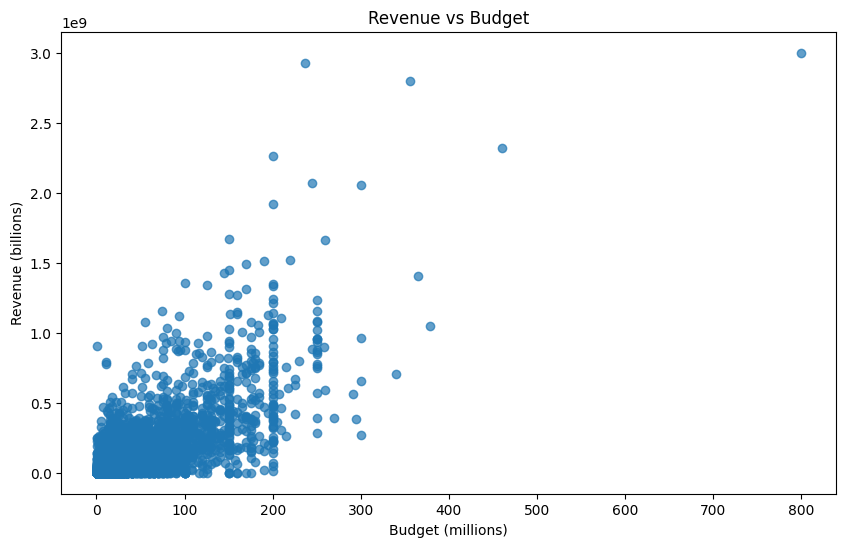

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(imdb_df['budget']/1e6, imdb_df['revenue'], alpha=0.7)

plt.xlabel('Budget (millions)')
plt.ylabel('Revenue (billions)')
plt.title('Revenue vs Budget')

plt.show()

### Now explore movies by country

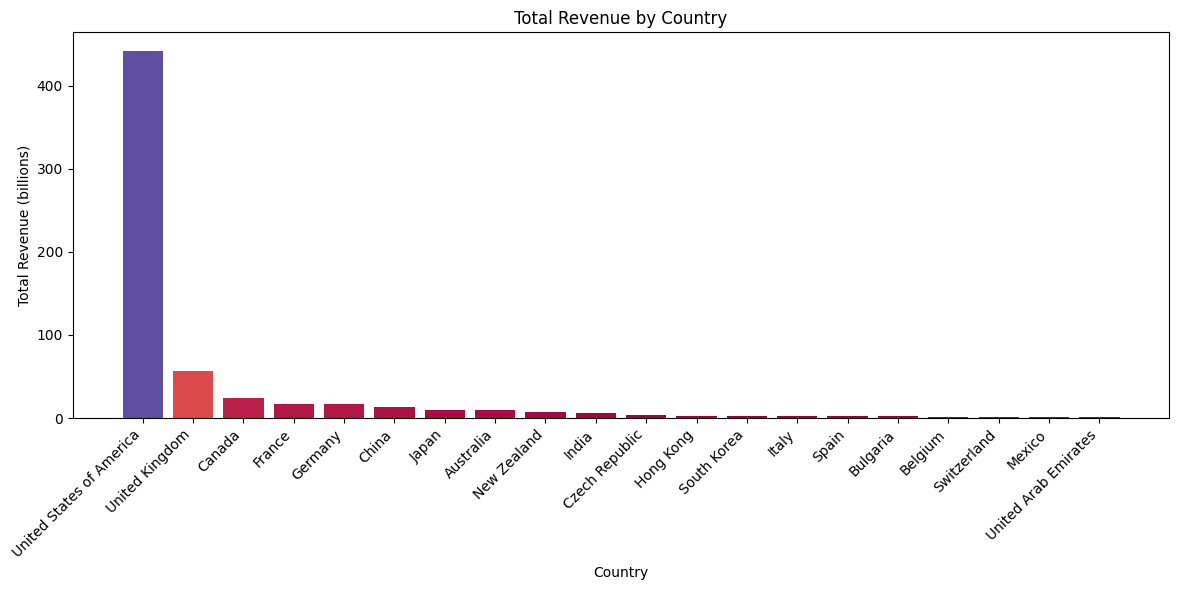

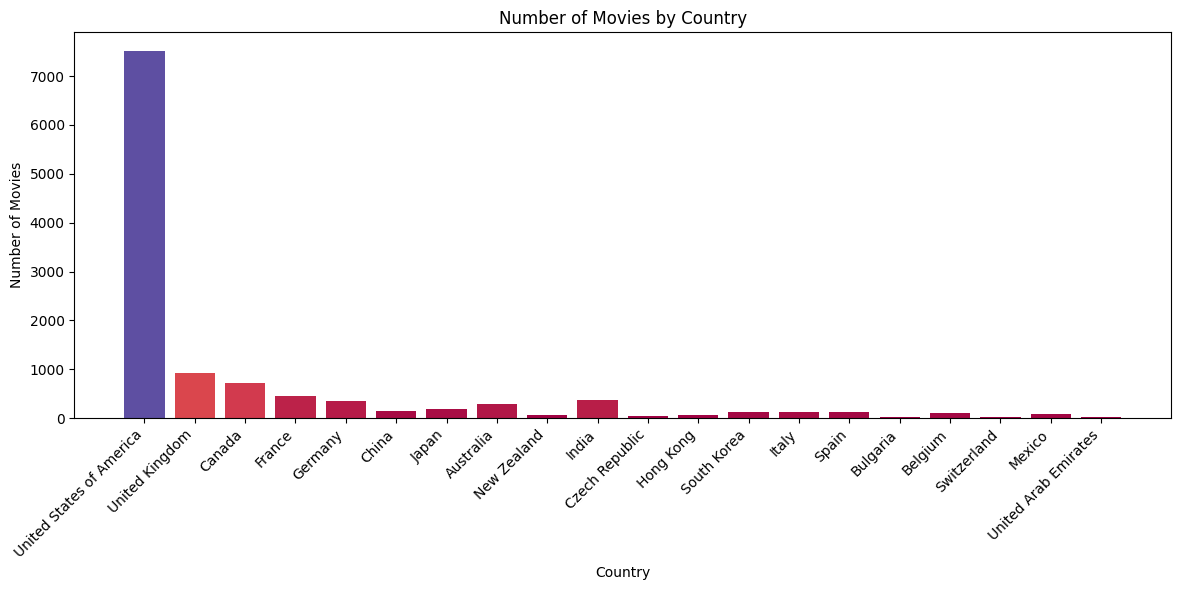

In [7]:
# data by country and sum the revenue for each country
imdb_df = imdb_df[imdb_df.production_countries.notna()]
imdb_df['country'] = imdb_df['production_countries'].apply(lambda x: str(x).split(',')[0])

revenue = imdb_df.groupby('country')['revenue'].sum().sort_values(ascending=False).head(20)

# filter to include only the top 20 countries by revenue
filtered_df = imdb_df[imdb_df['country'].isin(revenue.index)]

# colormap & normalize revenue
cmap = plt.cm.Spectral
normalize_revenue = plt.Normalize(vmin=min(revenue), vmax=max(revenue))

# movie counts by country for top revenue countries
movie_count = filtered_df['country'].value_counts().reindex(revenue.index).head(20)

# total revenue by country
plt.figure(figsize=(12, 6))
plt.bar(revenue.index, revenue.values / 1e9, color=cmap(normalize_revenue(revenue.values)))
plt.ylabel('Total Revenue (billions)')
plt.xlabel('Country')
plt.title('Total Revenue by Country')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# normalize the movie count values for cmap
normalize_movie_count = plt.Normalize(vmin=min(movie_count), vmax=max(movie_count))

# plot movie counts by country
plt.figure(figsize=(12, 6))
plt.bar(movie_count.index, movie_count.values, color=cmap(normalize_movie_count(movie_count.values)))
plt.xlabel('Country')
plt.ylabel('Number of Movies')
plt.title('Number of Movies by Country')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Setting up Word Freq Dataset

In [8]:
# Downloads: uncomment if you haven't done it yet
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('punkt')

# function to check if the word is in english. this uses sysnet
# to check if there's any meaningful definitions for the word
def is_english_word(word):
    return len(wordnet.synsets(word)) > 0

# function to remove stopwords and numbers from text
def preprocess_text(text):
    # lemmatizer : reduces word to dictionary form
    lemmatizer = WordNetLemmatizer()
    # stopwords : words that hold no meaning
    stop_words = set(stopwords.words('english'))
    stop_words.add('a')
    
    # tokenize text : split into words
    words = word_tokenize(text)
    words = [word for word in words if word not in string.punctuation]
    
    
    # remove stopwords, numbers, and single-character words
    # A IS STILL BEING INCLUDED: SOMEONE HELP PLS
    filtered_words = []
    for word in words:
        if word.lower() not in stop_words and not any(char.isdigit() for char in word)\
        and is_english_word(word.lower()):
            lemmatized = lemmatizer.lemmatize(word.lower())
            if len(lemmatized) > 1:
                filtered_words.append(lemmatized)
    
    # join the filtered words back into a single string
    processed_text = ' '.join(filtered_words)
    
    return processed_text

In [9]:
# get the most significant genre for each movie
imdb_df['genres'] = imdb_df['genres'].apply(lambda x: x.split(',')[0])

In [10]:
imdb_df = imdb_df[imdb_df.tagline.notna() & imdb_df.overview.notna()]
imdb_df.reset_index(inplace=True)

In [11]:
# combine text fields into one & preprocess the text
imdb_df['text'] = imdb_df['original_title'] + ' ' + imdb_df['overview'] + ' ' + imdb_df['tagline']

imdb_df['text'] = imdb_df['text'].apply(preprocess_text)
imdb_df['text']

0        inception skilled thief commits corporate espi...
1        interstellar adventure group explorer make use...
2        dark knight batman raise stake war crime help ...
3        avatar century paraplegic marine dispatched mo...
4        avenger unexpected enemy emerges threatens glo...
                               ...                        
12884    taboo wake tragic emotional event dobson lead ...
12885    thong girl outer space thong girl reluctantly ...
12886    four bottle finding get dream job decide going...
12887    sound scene south iran story musician omitted ...
12888    kali year old girl cambodia life grandmother l...
Name: text, Length: 12889, dtype: object

In [12]:
# split to x and y & training/test sets
x = imdb_df.text
y = imdb_df.genres
x_train, x_test, y_train, y_test = train_test_split(x,
                                            y, test_size=0.25,
                                            random_state=42)

# create a count vectorizer object on ONLY the training set
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(x_train)

# transform the training and validation data using count vectorizer object
# these are sparse matrixes with row being movie and col being word
xtrain_count =  count_vect.transform(x_train)
xtest_count =  count_vect.transform(x_test)

# convert sparse matrices to dfs
train_df = pd.DataFrame(xtrain_count.toarray(), columns=count_vect.get_feature_names_out())
test_df = pd.DataFrame(xtest_count.toarray(), columns=count_vect.get_feature_names_out())

# add y labels back to train_df and test_df as the first column
train_df.insert(0, 'genres', y_train.reset_index(drop=True))
test_df.insert(0, 'genres', y_test.reset_index(drop=True))

In [13]:
train_df

,genres,a,aa,aalto,aaron,ab,abandon,abandoned,abandoning,abandonment,...,zoned,zoo,zoological,zoologist,zoom,zu,zucchini,zulu,zurich,zwingli
0,Drama,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Action,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Science Fiction,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Comedy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Action,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9661,Documentary,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9662,Action,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9663,Comedy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9664,Fantasy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Wordcloud on training set!

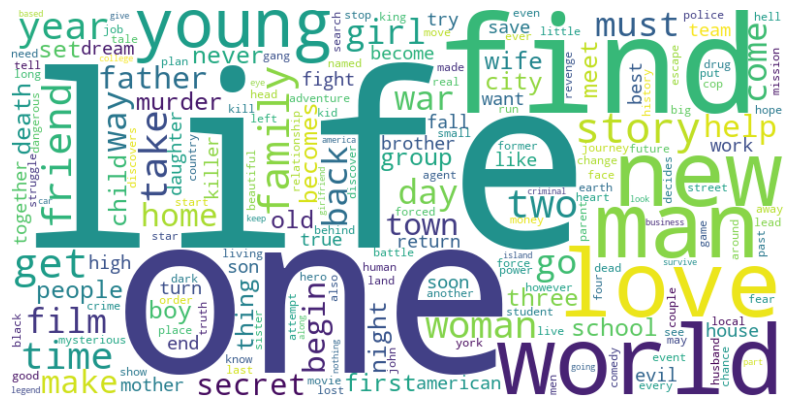

In [14]:
# sum all the columns
word_freqs = train_df.iloc[:, 1:].sum(axis=0).to_dict()

# word cloud object
wordcloud = WordCloud(width=800, height=400, 
                      background_color='white',
                     colormap='viridis').generate_from_frequencies(word_freqs)

# display the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [15]:
train_df.to_csv(r'/Users/sarakent/Desktop/ML 1/train_df.csv')
test_df.to_csv(r'/Users/sarakent/Desktop/ML 1/test_df.csv')